#  Pathway Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(42)

# See https://github.com/h5py/h5py/issues/712
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" 

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load TCGA+TARGET+GTEX

In [2]:
X = pd.read_hdf("data/tcga_target_gtex.h5", "expression")
Y = pd.read_hdf("data/tcga_target_gtex.h5", "labels")

## Ingest Pathways

Load gene sets downloaded from msigdb filter out data to only include gene's present in the union of all the pathways

In [3]:
# Load gene sets from downloaded MSigDB gmt file
# KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = {line.strip().split("\t")[0]: line.strip().split("\t")[2:]
                 for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop  genes not in X - sort so order is the same as X_pruned.columns
gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values])
             for name, genes in gene_sets.items()}

# Find union of all gene's in all gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19126, 5172)


## Wrangle Labels

Convert tumor/normal, primary site and disease into one hot outputs and combine into a single multi-class multi-label output vectoro to train against.

In [4]:
# Convert  primary_site into numerical values for one-hot multi-class training
from sklearn.preprocessing import LabelEncoder

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(
    tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index)

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(
    primary_site_encoder.fit_transform(Y["primary_site"]), index=Y.index)

disease_encoder = LabelEncoder()
Y["disease_value"] = pd.Series(
    disease_encoder.fit_transform(Y["disease"]), index=Y.index)

Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value,disease_value
count,19126,19126,19126,19126,19126,19126,19126,19126.000000,19126.000000,19126.000000
unique,93,93,46,16,3,3,2,NaN,NaN,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN,NaN,NaN
freq,1212,1212,1846,9185,10453,10534,10530,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550559,20.651992,48.639757
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497450,12.419634,25.847654
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,19.000000,51.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000,92.000000


In [5]:
# Create a multi-class one hot output all three classifications
from keras.utils import np_utils
Y_onehot = np.append(
    Y["tumor_normal_value"].values.reshape(Y.shape[0],-1), 
    np_utils.to_categorical(Y["primary_site_value"]), axis=1)
Y_onehot = np.append(Y_onehot,
    np_utils.to_categorical(Y["disease_value"]), axis=1)
print(Y_onehot.shape)

(19126, 140)


## Stratify Split into Train/Test

Split the data into training and test sets stratified by primary side. Check that we get a good distribution of both primary site and disease between each of these sets.

In [6]:
# Split into stratified training and test sets based primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["primary_site_value"]):
    X_train = X_pruned.values[train_index]
    X_test = X_pruned.values[test_index]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
    y_train = Y_onehot[train_index]
    y_test = Y_onehot[test_index]
    primary_site_train = Y["primary_site_value"].values[train_index]
    primary_site_test = Y["primary_site_value"].values[test_index]
    disease_train = Y["disease_value"].values[train_index]
    disease_test = Y["disease_value"].values[test_index]

print(X_train.shape, X_test.shape)

(15300, 5172) (3826, 5172)


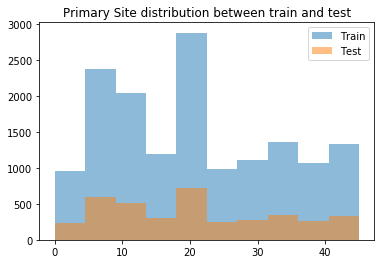

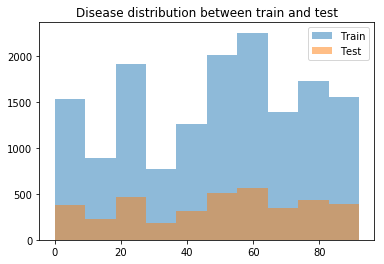

In [7]:
# Lets see how big each class is based on primary site
plt.hist(primary_site_train, alpha=0.5, label='Train')
plt.hist(primary_site_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Primary Site distribution between train and test")
plt.show()

# Lets see how big each class is based on primary site
plt.hist(disease_train, alpha=0.5, label='Train')
plt.hist(disease_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Disease distribution between train and test")
plt.show()

## Primary Site Classification w/Per Pathway Sub-Network Input Layer
For each pathway build a custom input layer that extracts the expression levels for the genes in the pathway from the full input vector and feeds this into a dense single output hidden neuron. These are then aggregated and fed into a standard set of stacked layers and trained to classify tumor/norml and primary site. The hidden per pathway neurons are named after the pathway an 'may' indicate which pathway lead to a given classification.

In [8]:
# Convert list of gene names into list of indexes into  features of X_pruned
gene_set_indexes = {name: np.searchsorted(X_pruned.columns.values, genes)
                    for name, genes in gene_sets.items()}
print("Pathway KEGG_ABC_TRANSPORTERS Gene Indexes:",
      gene_set_indexes["KEGG_ABC_TRANSPORTERS"])

Pathway KEGG_ABC_TRANSPORTERS Gene Indexes: [  11   12   13   14   15   16   17   18   19   20   21   22   23   24
   25   26   27   28   29   30   31   32   33   34   35   36   37   38
   39   40   41   42   43   44   45   46   47   48   49   50   51  848
 4692 4693]


In [9]:
%%time
from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.merge import concatenate
from keras import backend as K
import itertools

main_input = Input(shape=(X_train.shape[1],), name="main_input")

x = main_input

x = BatchNormalization()(x)

"""
Build per pathway sub-networks
"""
# Set to a small number (~4) for debugging, set to None to build all pathways
# max_num_pathways = 4
max_num_pathways = None

# Extract features/gene's for each pathway from the aggregate x input vector
x = [Lambda(lambda e: K.concatenate([e[:, i:i+1] for i in indexes]))(x)
            for name, indexes in itertools.islice(gene_set_indexes.items(), max_num_pathways)]

# Add a dense layer per pathway with width proportional to the number of genes in the pathway
x = [Dense(max(2, len(i)//4), activation='relu')(p) 
     for p, i in zip(x, gene_set_indexes.values())]

# Add a named binary output for each pathway
x = [Dense(1, activation='relu', name=name)(p) 
     for p, name in zip(x, gene_set_indexes.keys())]

# Concatenate binary outputs of each of  sub-networks back into single vector
x = keras.layers.concatenate(x, name="pathways")

"""
Add traditional stacked network for final multi-label classification
"""

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activity_regularizer=regularizers.l1(1e-5), activation='relu')(x)
x = Dropout(0.5)(x)

main_output = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(inputs=[main_input], outputs=[main_output])
# print(model.summary())  # Too detailed when building full set of pathways
print("Trainable params::", np.sum(
    [np.product(v.shape) for v in model.trainable_weights]).value)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Trainable params:: 436180
CPU times: user 1min 32s, sys: 1.98 s, total: 1min 34s
Wall time: 1min 34s


In [10]:
%%time
callbacks = [EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=10, batch_size=128, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, y_test))

Epoch 1/10
15300/15300 [==============================] - 1516s 99ms/step - loss: 0.2750 - acc: 0.9314
Epoch 2/10
15300/15300 [==============================] - 920s 60ms/step - loss: 0.1389 - acc: 0.9842
Epoch 3/10
15300/15300 [==============================] - 950s 62ms/step - loss: 0.1195 - acc: 0.9850
Epoch 4/10
15300/15300 [==============================] - 976s 64ms/step - loss: 0.1075 - acc: 0.9855
Epoch 00004: early stopping
3826/3826 [==============================] - 29s 7ms/step
['loss', 'acc'] [0.06230655767635033, 0.9865656361427846]
CPU times: user 9h 1min 7s, sys: 2d 18h 6min 39s, total: 3d 3h 7min 47s
Wall time: 1h 14min 13s


## Evaluate Model

In [11]:
%%time
# Predict all test samples
predictions = model.predict(X_test)

# Build a mode to access the activiations of the pathway layer
pathway_model = Model(inputs=model.layers[0].input, outputs=model.get_layer("pathways").output)
pathway_predictions = pathway_model.predict(X_test)

CPU times: user 1min 37s, sys: 22.2 s, total: 1min 59s
Wall time: 56.8 s


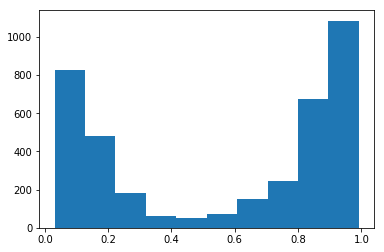

In [12]:
# First lets look at the distribution of our binary tumor/normal predictions
plt.hist(predictions[:,0])
plt.show()

In [13]:
# Create a new dataframe of the test original and predicted labels
Y_test_predictions = Y_test.copy()

Y_test_predictions["predicted_tumor_normal"] = ["Normal ({:0.2f})".format(p) if np.round(p) <= 0.5 
                                                else "Tumor ({:0.2f})".format(p)
                                                for p in predictions[:,0]]

labels = primary_site_encoder.classes_.tolist()
Y_test_predictions["predicted_primary_site"] = [
    ", ".join(["{} ({:0.2f})".format(labels[i], p[1:1+46][i]) for i in p[1:1+46].argsort()[-3:][::-1]])
    for i, p in enumerate(predictions)]


labels = disease_encoder.classes_.tolist()
Y_test_predictions["predicted_disease"] = [
    ", ".join(["{} ({:0.2f})".format(labels[i], p[1+46:-1][i]) for i in p[1+46:-1].argsort()[-3:][::-1]])
    for i, p in enumerate(predictions)]

labels = list(gene_sets.keys())
Y_test_predictions["predicted_pathways"] = [
    ", ".join(["{} ({:0.2f})".format(labels[i], p[i]) for i in p.argsort()[-3:][::-1]])
    for i, p in enumerate(pathway_predictions)]

Y_test_predictions.to_csv("models/Y_test_predictions.tsv", sep="\t")

Y_test_predictions.head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value,disease_value,predicted_tumor_normal,predicted_primary_site,predicted_disease,predicted_pathways
id,,,,,,,,,,,,,,
GTEX-WWTW-0008-SM-4MVPE,Cells - Transformed Fibroblasts,Cells - Transformed Fibroblasts,Skin,Cell Line,Male,GTEX,Normal,0,33,30,Normal (0.17),"Skin (0.38), Esophagus (0.06), Colon (0.06)","Cells - Transformed Fibroblasts (0.09), Skin -...","KEGG_HEMATOPOIETIC_CELL_LINEAGE (5.96), KEGG_C..."
GTEX-YEC3-0826-SM-4WWFP,Thyroid,Thyroid,Thyroid,Normal Tissue,Male,GTEX,Normal,0,41,84,Normal (0.08),"Esophagus (0.10), Skin (0.09), Blood Vessel (0...","Thyroid (0.05), Skin - Sun Exposed (Lower Leg)...","KEGG_CALCIUM_SIGNALING_PATHWAY (3.48), KEGG_TI..."
GTEX-OOBJ-1626-SM-2I3F7,Muscle - Skeletal,Muscle - Skeletal,Muscle,Normal Tissue,Male,GTEX,Normal,0,24,61,Normal (0.06),"Muscle (0.13), Esophagus (0.12), Skin (0.11)","Muscle - Skeletal (0.12), Whole Blood (0.08), ...",KEGG_VASOPRESSIN_REGULATED_WATER_REABSORPTION ...
TCGA-D3-A2JL-06,Skin Cutaneous Melanoma,Skin Cutaneous Melanoma,Skin,Metastatic,Female,TCGA,Tumor,1,33,76,Tumor (0.93),"Skin (0.10), Lung (0.09), Breast (0.08)","Breast Invasive Carcinoma (0.07), Skin Cutaneo...",KEGG_VASCULAR_SMOOTH_MUSCLE_CONTRACTION (2.80)...
GTEX-1313W-0926-SM-5EQ56,Lung,Lung,Lung,Normal Tissue,Female,GTEX,Normal,0,22,56,Normal (0.33),"Lung (0.24), Breast (0.07), Skin (0.07)","Lung Adenocarcinoma (0.11), Lung Squamous Cell...","KEGG_MAPK_SIGNALING_PATHWAY (3.64), KEGG_VASCU..."


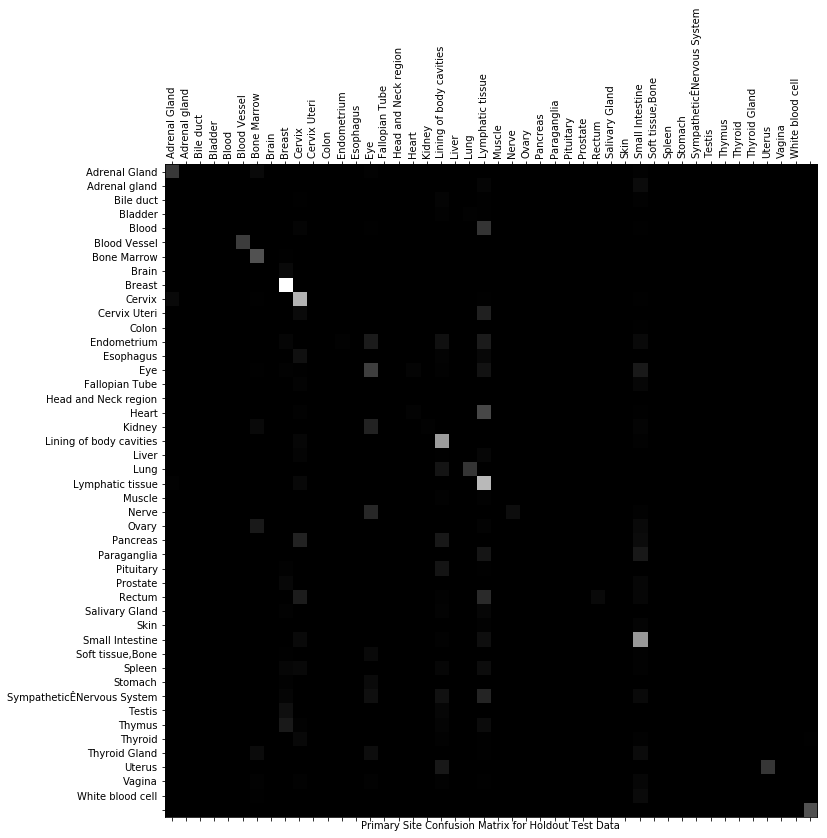

In [14]:
# Plot confusion matrix for primary site
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    primary_site_test, np.array([np.argmax(p[1:1+46]) for p in predictions]))

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.gray)
ax.set_xticklabels(primary_site_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(primary_site_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Primary Site Confusion Matrix for Holdout Test Data")
plt.show()

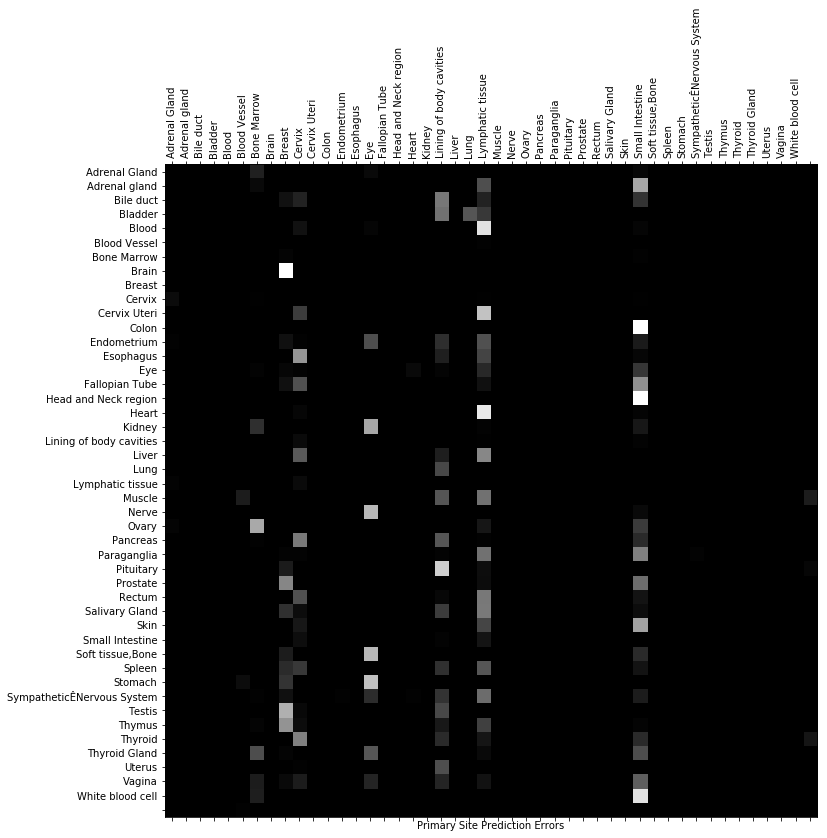

In [15]:
# Show only where there are errors
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.gray)
ax.set_xticklabels(primary_site_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(primary_site_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Primary Site Prediction Errors")
plt.show()

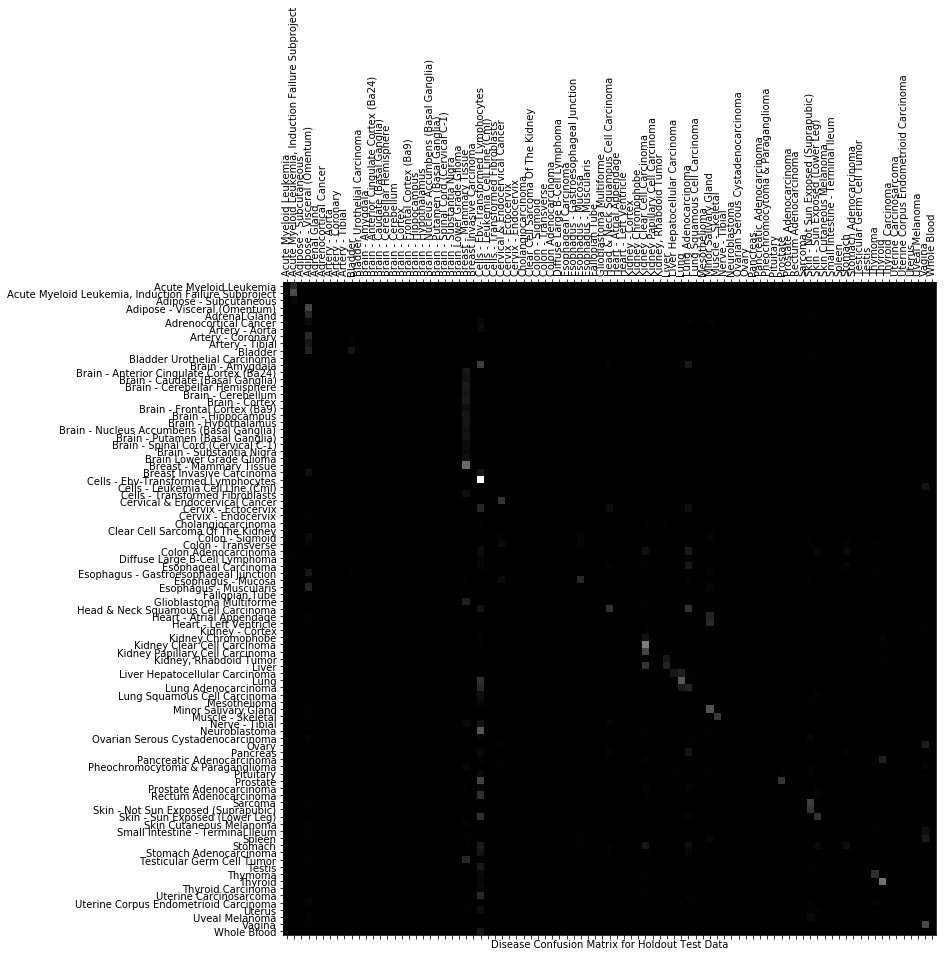

In [16]:
# Plot confusion matrix for disease
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    disease_test, np.array([np.argmax(p[1+46:-1]) for p in predictions]))

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.gray)
ax.set_xticklabels(disease_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(disease_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Disease Confusion Matrix for Holdout Test Data")
plt.show()

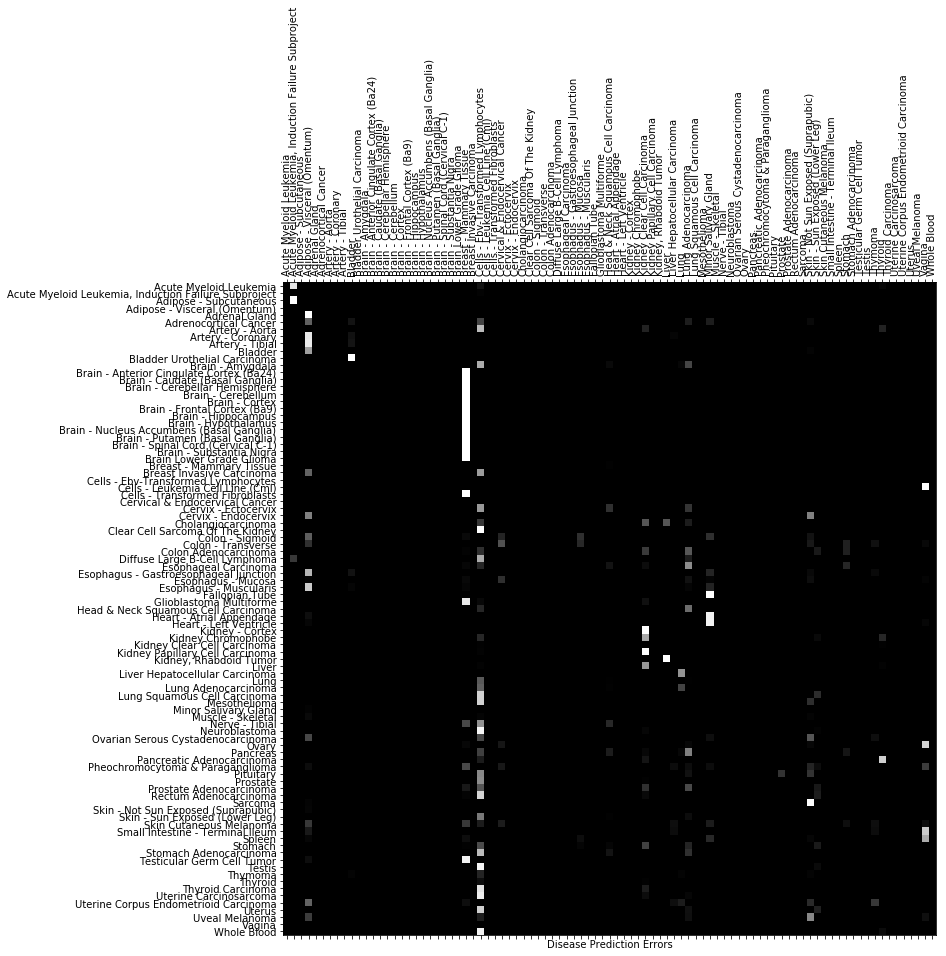

In [17]:
# Show only where there are errors
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.gray)
ax.set_xticklabels(disease_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(disease_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Disease Prediction Errors")
plt.show()

## Predict Treehouse

Predict all Treehouse samples and look up the top pathways from tertiary analysis for comparison to the predictions for the pathways interior hidden layer.

In [18]:
# Load and prepare for predicting
X_treehouse = pd.read_hdf("data/treehouse.h5", "expression")
Y_treehouse = pd.read_hdf("data/treehouse.h5", "labels")

X_treehouse_pruned = X_treehouse.drop(labels=(set(X_treehouse.columns) - set(all_gene_set_genes)), 
                            axis=1, errors="ignore")

In [19]:
# Load clinical Treehouse data
import glob

treehouse_clinical = pd.read_csv(
    "/treehouse/archive/compendium/v4/clin.essential.final_v4_20170420.tsv",
    sep="\t", index_col=0)

# Extract top 3 pathways from Treehouse GSEA Top 5 tertiary output
top_gsea_paths = {
    id: sorted(
        glob.glob(
            "/treehouse/archive/downstream/{}/tertiary/treehouse-protocol*/compendium*/gsea_*_top5" \
            .format(id)))
    for id in Y_treehouse.index.values}

top_gsea_pathways = pd.DataFrame({
    id: pd.read_csv(path[-1], sep="\t", header=6, nrows=10).sort_values(
        by=["k/K"], axis=0, ascending=False)["Gene Set Name"][0:3].values
    for id, path in top_gsea_paths.items() if path}).T

top_gsea_pathways.head()

,0,1,2
TH01_0051_S01,KEGG_RIBOSOME,HALLMARK_MYC_TARGETS_V1,HALLMARK_OXIDATIVE_PHOSPHORYLATION
TH01_0053_S01,KEGG_RIBOSOME,HALLMARK_MYC_TARGETS_V1,REACTOME_MRNA_SPLICING
TH01_0054_S01,KEGG_RIBOSOME,HALLMARK_MYC_TARGETS_V1,HALLMARK_OXIDATIVE_PHOSPHORYLATION
TH01_0055_S01,KEGG_RIBOSOME,HALLMARK_MYC_TARGETS_V1,HALLMARK_OXIDATIVE_PHOSPHORYLATION
TH01_0061_S01,KEGG_RIBOSOME,HALLMARK_MYC_TARGETS_V1,HALLMARK_OXIDATIVE_PHOSPHORYLATION


In [20]:
%%time
# Predict all test samples
predictions = model.predict(X_treehouse_pruned)

# Build a mode to access the activiations of the pathway layer
pathway_model = Model(inputs=model.layers[0].input, outputs=model.get_layer("pathways").output)
pathway_predictions = pathway_model.predict(X_treehouse_pruned)

CPU times: user 26.2 s, sys: 3.55 s, total: 29.7 s
Wall time: 21 s


In [21]:
# Add predictions to our label dataframe
Y_treehouse["predicted_tumor_normal"] = ["Normal ({:0.2f})".format(p) if np.round(p) <= 0.5 
                                                else "Tumor ({:0.2f})".format(p)
                                                for p in predictions[:,0]]

labels = primary_site_encoder.classes_.tolist()
Y_treehouse["predicted_primary_site"] = [
    ", ".join(["{} ({:0.2f})".format(labels[i], p[1:1+46][i]) for i in p[1:1+46].argsort()[-3:][::-1]])
    for i, p in enumerate(predictions)]


labels = disease_encoder.classes_.tolist()
Y_treehouse["predicted_disease"] = [
    ", ".join(["{} ({:0.2f})".format(labels[i], p[1+46:-1][i]) for i in p[1+46:-1].argsort()[-3:][::-1]])
    for i, p in enumerate(predictions)]

labels = list(gene_sets.keys())
Y_treehouse["predicted_pathways"] = [
    ", ".join(["{} ({:0.2f})".format(labels[i], p[i]) for i in p.argsort()[-3:][::-1]])
    for i, p in enumerate(pathway_predictions)]

Y_treehouse.head()

,age_in_years,gender,disease,predicted_tumor_normal,predicted_primary_site,predicted_disease,predicted_pathways
id,,,,,,,
TH01_0051_S01,nan,Not Reported,Hepatoblastoma,Tumor (0.78),"Kidney (0.13), Liver (0.08), Lung (0.06)","Kidney Clear Cell Carcinoma (0.10), Liver Hepa...","KEGG_ABC_TRANSPORTERS (2.66), KEGG_ARGININE_AN..."
TH01_0053_S01,nan,Not Reported,Acute Myeloid Leukemia,Tumor (0.61),"White blood cell (0.21), Blood (0.19), Skin (0...","Acute Myeloid Leukemia (0.16), Whole Blood (0....","KEGG_LIMONENE_AND_PINENE_DEGRADATION (3.06), K..."
TH01_0054_S01,nan,Not Reported,Acute Lymphoblastic Leukemia,Tumor (0.52),"Blood (0.24), White blood cell (0.18), Stomach...","Whole Blood (0.15), Acute Myeloid Leukemia (0....","KEGG_FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS (3.72), ..."
TH01_0055_S01,nan,Not Reported,Glioma,Tumor (0.55),"Brain (0.62), Esophagus (0.05), Kidney (0.05)","Brain Lower Grade Glioma (0.19), Head & Neck S...","KEGG_CALCIUM_SIGNALING_PATHWAY (4.30), KEGG_GL..."
TH01_0061_S01,nan,Not Reported,Germ Cell Tumor,Tumor (0.77),"Kidney (0.17), Lung (0.12), Liver (0.09)","Kidney Clear Cell Carcinoma (0.11), Breast Inv...",KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS (...


In [22]:
# Merge treehouse clinical and top gsea paths and write out
Y_treehouse.join(
    [treehouse_clinical.Anatomical_location, top_gsea_pathways]
).to_csv("models/Y_treehouse_predictions.tsv", sep="\t")